# Machine Learning
## Assignment - 2
written by : Jameel Ahmed Syed
email : j.syed@innopolis.university

# Task - 2

<hr>

Contents
(i) Data Reading, Exploration and preprocessing;
   1. Import All the Necessary Libraries
   2. Custom class for MinMax scaling
   3. Downloading and transforming the train and test datasets
   4. Split the data to train (70%), validation (10%) and test (20%)
   5. Class labels
   6. Display the preprocessed image from the dataloader
   7. Hyperparameters initialization
   8. Display the grid of images from the dataloader

(ii) Machine learning or Deep learning model defining, training and hyperparameters turning and
(iii) Model performance evaluation
   1. Baseline Neural Network class
   2. Simple Neural Network Training and Testing Loop Functions
   4. Loss and Optimizers
   5. Training the model and Evaluation metrics

(iv) Conclusion and possible improvements

# Task 2.1

# (i) Data Reading, Exploration and preprocessing;

### 1. Import All the Necessary Libraries

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report
from torch.utils.data import random_split
import numpy as np
import pandas as pd
import cv2
from torchvision import models
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

### 2. Custom class for MinMax scaling

In [3]:
class CustomMinMaxScaler:
    """
    This is a class for Custom MinMax Scaling for the images.
    It is to be used as a transform
    Parameters:
        sample: The image.
    """
    def __init__(self):
        self.scaler = MinMaxScaler()

    def __call__(self, sample):
        image = sample
        #print("THis is the image",image.shape)
        temp = image.reshape(-1, 3)
        scaled = self.scaler.fit_transform(temp)
        transformed = torch.from_numpy(scaled.reshape(image.shape).astype(np.float32))
        #print("Transformed image", transformed.shape)
        return transformed

### 3. Downloading and transforming the train and test datasets

In [128]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    CustomMinMaxScaler()])

train_dataset = torchvision.datasets.GTSRB('./data',
                                         transform=transform,
                                         download=True)
test_dataset = torchvision.datasets.GTSRB('./data',
                                        split='test',
                                        transform=transform,
                                        download=True)

  0%|          | 0/187490228 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 4. Split the data to train (70%), validation (10%) and test (20%)

In [5]:
train_len = len(train_dataset)
test_len = len(test_dataset)
print(f"Train len: {train_len}, Test len: {test_len}")
total_len = train_len + test_len
print(f"Total len: {total_len}")

new_val_len = int(0.31 * test_len)
new_test_len = int(test_len-new_val_len)

val_dataset, test_dataset = random_split(test_dataset,[new_val_len, new_test_len])
print(f"Val len: {new_val_len}, Test len: {new_test_len}")

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=50)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

Train len: 26640, Test len: 12630
Total len: 39270
Val len: 3915, Test len: 8715


### 5. Class labels

In [6]:
classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'No passing',
            'No passing veh over 3.5 tons',
            'Right-of-way at intersection',
            'Priority road',
            'Yield',
            'Stop',
            'No vehicles',
            'Veh > 3.5 tons prohibited',
            'No entry',
            'General caution',
            'Dangerous curve left',
            'Dangerous curve right',
            'Double curve',
            'Bumpy road',
            'Slippery road',
            'Road narrows on the right',
            'Road work',
            'Traffic signals',
            'Pedestrians',
            'Children crossing',
            'Bicycles crossing',
            'Beware of ice/snow',
            'Wild animals crossing',
            'End speed + passing limits',
            'Turn right ahead',
            'Turn left ahead',
            'Ahead only',
            'Go straight or right',
            'Go straight or left',
            'Keep right',
            'Keep left',
            'Roundabout mandatory',
            'End of no passing',
            'End no passing veh > 3.5 tons')

### 6. Display the preprocessed image from the dataloader

torch.Size([50, 3, 32, 32])
No passing veh over 3.5 tons


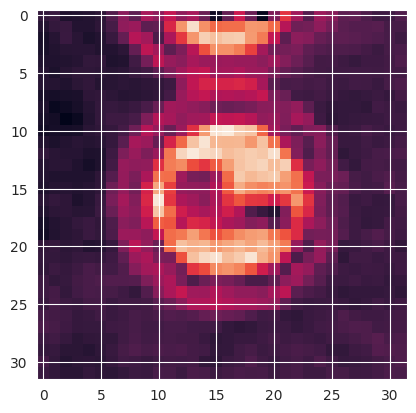

In [7]:
images, labels = next(iter(train_dataloader))
#print(images[0], labels[0])
print(images.shape)
plt.imshow(images[0][0])
print(classes[labels[0]])

In [8]:
#cv2.imshow('test', np.array(images[0][0]).astype(np.float32))
#cv2.waitKey(0) # waits until a key is pressed
#cv2.destroyAllWindows()

### 7. Hyperparameters initialization

In [9]:
# hyper parameters
input_size = 3
n_classes = 43
n_epochs = 20
batch_size = 200
learning_rt = 0.001

### 8. Display the grid of images from the dataloader

GroundTruth: 
 General caution, Turn right ahead, Children crossing, No vehicles,


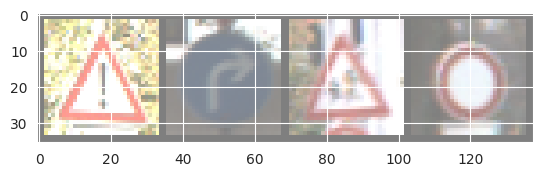

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_dataloader)
images, labels = next(dataiter)

#print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: \n', ' '.join('%5s,' % classes[labels[j]] for j in range(4)))

# (ii) Machine learning or Deep learning model defining, training and hyperparameters turning and (iii) Model performance evaluation

### 1. Baseline Neural Network class

In [11]:
class NeuralNet(torch.nn.Module):
    """
    It is a simple Baseline Model as per the home-work details.
    """
    def __init__(self, input_size, n_classes):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.Sequential(
        nn.Conv2d(input_size, 32, 3, stride=1, padding=1),   # Conv 1 (32, 32, 32)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Conv2d(32, 32, 3, stride=1, padding=1),  # Conv 2 (32, 32, 32)
        nn.MaxPool2d(2, 2),                         # Pool 1 (32, 16, 16)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, 3, stride=1, padding=1),  # Conv 3 (64, 16, 16)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Conv2d(64, 64, 3, stride=1, padding=1),  # Conv 4 (64, 16, 16)
        nn.MaxPool2d(2, 2),                         # Pool 2 (64, 8, 8)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Conv2d(64, 128, 3, stride=1, padding=1), # Conv 5 (128, 8, 8)
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Conv2d(128, 128, 3, stride=1, padding=1),# Conv 6 (128, 8, 8)
        nn.MaxPool2d(2, 2),                         # Pool 3 (128, 4, 4)
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Flatten(),                               # Flat 1 (2048) i.e 128x4x4
        nn.Linear(2048, 512),                       # Lin 1 (512)
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),

        nn.Linear(512, n_classes),                         # Lin 2 (43)
        #nn.Softmax(dim=1),                          # Softmax (43)
        )

    def forward(self, x):
        out = self.layers(x)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = NeuralNet(input_size=input_size, n_classes=n_classes).to(device)

cuda


In [12]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
         MaxPool2d-6           [-1, 32, 16, 16]               0
       BatchNorm2d-7           [-1, 32, 16, 16]              64
              ReLU-8           [-1, 32, 16, 16]               0
           Dropout-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

### 2. Tensorboard Initialization for Task-2.1

In [13]:
writer = SummaryWriter("runs/task2-1")

2022-11-20 21:34:24.616129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:34:24.777464: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 21:34:25.432672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/syed/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-20 21:34:25.432742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7';

In [14]:
#!tensorboard --logdir=runs

### 3. Simple Neural Network Training and Testing Loop Functions

In [30]:
n_correct = 0
n_samples = 0
plot_loss = []
plot_accuracy = []
from sklearn.metrics import f1_score

def train(model, dataloader, val_dataloader, optimizer, criterion, device, nth_model=1):
    """This Functions purpose is to train the model
    :param model: The model which we need to train
    :param dataloader: The dataset which we need to train on
    :param optimizer: The optimizer function by which the weights are to be updated
    :param criterion: The loss function
    :param device: cuda or cpu (On which device the model will be trained)
    """
    # training loop
    model.train()
    model_list = []
    global plot_loss, plot_accuracy
    plot_loss = []
    plot_accuracy = []
    running_loss = 0.0
    running_correct = 0
    running_acc = 0.0
    n_total_steps = len(train_dataloader)
    for epoch in range(n_epochs):

        running_loss = 0.0
        running_acc = 0.0
        for i, (data, labels) in enumerate(dataloader):

            labels = labels.type(torch.LongTensor)
            data = data.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(data)
            labels = labels

            # Loss
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # recording Loss and correct Predictions
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()

            #if (i+1) % 100 == 0:
        print(f"\nModel [{nth_model}/{nth_model}], Epoch: [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], loss = {loss.item():.4f}, ", end="")

        train_acc, train_f1 = test(model, train_dataloader, device, name=f"Train acc")
        val_acc, val_f1 = test(model, val_dataloader, device, name=f"Val acc")
        test_acc, test_f1 = test(model, test_dataloader, device, name=f"Test acc")

        model_list.append(model)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Val', val_acc, epoch)
        writer.add_scalar('Accuracy/Test', test_acc, epoch)

        writer.add_scalar('F1_Score/Train', train_f1, epoch)
        writer.add_scalar('F1_Score/Val', val_f1, epoch)
        writer.add_scalar('F1_Score/Test', test_f1, epoch)

        running_loss /= len(dataloader)
        writer.add_scalar('Loss/Train', running_loss, epoch)
        #for tag,parm in model.named_parameters():
        #    writer.add_histogram(tag, parm.grad.data.cpu().numpy(), epoch)
    writer.flush()
    print(f"Training Ends")
    return model


def test(model, dataloader, device, name="Test"):
    """This Functions purpose is to test the model
    :param model: The model which we need to test
    :param dataloader: The dataset which we need to test on
    :param device: cuda or cpu (On which device the model will be tested)
    :param name: The name of the test dataset (Train, Validation or Test datasets)
    """
    # Testing
    #print(f" Testing of {name} dataset begins")
    model.eval()
    with torch.no_grad():
        global n_correct, n_samples
        n_correct, n_samples = 0, 0
        for i, (data, labels) in enumerate(dataloader):
            labels = labels.type(torch.LongTensor)
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)

            # value, index
            _, predictions = torch.max(outputs, 1)
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        f1 = f1_score(np.array(labels.cpu()).astype(np.float32), np.array(predictions.cpu()).astype(np.float32), average='macro')
        acc = 100.0 * n_correct /n_samples
        print(f"{name}: {acc:.2f}, f1: {f1:.2f} ", end="")
    return acc, f1

### 4. Loss and Optimizers

Lables in sequence are:

No passing veh over 3.5 tons
Priority road
Ahead only
No entry
Yield
Speed limit (60km/h)


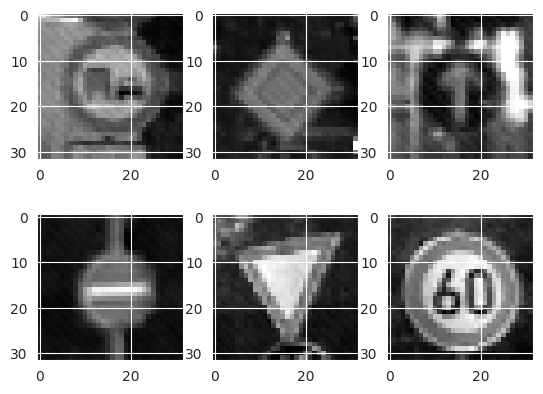

In [31]:
# loss and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rt, momentum=0.9, weight_decay=0.00001)

data, labels = next(iter(train_dataloader))

print("Lables in sequence are:\n")
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(data[i][0], cmap='gray')
  print(classes[labels[i]])
#plt.show()
img_grid = torchvision.utils.make_grid(data)

writer.add_image('Task 2.1', img_grid)
writer.close()


### 5. Training the model and Evaluation metrics

In [17]:
model = train(model=model, dataloader=train_dataloader,val_dataloader=val_dataloader, optimizer=optimizer, criterion=criterion, device=device)


Model [1/1], Epoch: [1/20], Step [533/533], loss = 1.8828, Train acc: 36.64, f1: 0.33 Val acc: 31.26, f1: 0.00 Test acc: 31.41, f1: 0.00 
Model [1/1], Epoch: [2/20], Step [533/533], loss = 0.0449, Train acc: 97.25, f1: 0.98 Val acc: 87.46, f1: 0.00 Test acc: 87.50, f1: 0.00 
Model [1/1], Epoch: [3/20], Step [533/533], loss = 0.0086, Train acc: 99.46, f1: 1.00 Val acc: 91.19, f1: 1.00 Test acc: 91.08, f1: 1.00 
Model [1/1], Epoch: [4/20], Step [533/533], loss = 0.0338, Train acc: 99.88, f1: 1.00 Val acc: 92.77, f1: 1.00 Test acc: 92.15, f1: 1.00 
Model [1/1], Epoch: [5/20], Step [533/533], loss = 0.0005, Train acc: 99.95, f1: 1.00 Val acc: 93.15, f1: 1.00 Test acc: 93.05, f1: 1.00 
Model [1/1], Epoch: [6/20], Step [533/533], loss = 0.0000, Train acc: 100.00, f1: 1.00 Val acc: 93.41, f1: 1.00 Test acc: 93.20, f1: 1.00 
Model [1/1], Epoch: [7/20], Step [533/533], loss = 0.0000, Train acc: 99.99, f1: 1.00 Val acc: 93.23, f1: 1.00 Test acc: 92.90, f1: 1.00 
Model [1/1], Epoch: [8/20], Step

### Observation:
#### There is an overfit in the training but the Validation and test accuracys are good


# Task 2.2

### 1. Get the pretrained resnet18 model from the torchvision and freeze the model

In [112]:
from torchvision import models
model = models.resnet18(pretrained=True)
model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

/home/syed/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syed/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2. Print the model

In [113]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. Assign the Layers

In [114]:
model.classifier = nn.Linear(1024,43)
model.classifier.requires_grad_(True)
model.classifier =  torch.nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024,43),)
model.classifier.requires_grad_(True)
model.layer4.requires_grad_(True)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

### 4. Print the list of Learning paramenters

In [115]:
print("Learning parameters are:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Learning parameters are:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 classifier.1.weight
	 classifier.1.bias


### 5. Custom MinMax Scaler class

In [116]:
from sklearn.preprocessing import MinMaxScaler

class CustomMinMaxScaler:
    """
    This is a class for Custom MinMax Scaling for the images.
    It is to be used as a transform
    Parameters:
        sample: The image.
    """
    def __init__(self):
        self.scaler = MinMaxScaler()

    def __call__(self, sample):
        image = sample
        #print("THis is the image",image.shape)
        temp = image.reshape(-1, 3)
        scaled = self.scaler.fit_transform(temp)
        transformed = torch.from_numpy(scaled.reshape(image.shape).astype(np.float32))
        #print("Transformed image", transformed.shape)
        return transformed

### 6. Get the datasets and transform them

In [117]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    CustomMinMaxScaler(),
    ])

train_dataset = torchvision.datasets.GTSRB('./data',
                                         transform=transform,
                                         download=True)
test_dataset = torchvision.datasets.GTSRB('./data',
                                        split='test',
                                        transform=transform,
                                        download=True)

### 7. Loss and Optimizer

In [118]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

### 8. Loading all the datasets into the Dataloaders

In [119]:
train_len = len(train_dataset)
test_len = len(test_dataset)
print(f"Train len: {train_len}, Test len: {test_len}")
total_len = train_len + test_len
print(f"Total len: {total_len}")

new_val_len = int(0.31 * test_len)
new_test_len = int(test_len-new_val_len)

val_dataset, test_dataset = random_split(test_dataset,[new_val_len, new_test_len])
print(f"Val len: {new_val_len}, Test len: {new_test_len}")

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=50)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

Train len: 26640, Test len: 12630
Total len: 39270
Val len: 3915, Test len: 8715


### 9. Initialize the summary writer

In [120]:
writer = SummaryWriter("runs/task2-2")

### 10. Training the model

In [127]:
def train(model,epochs,data_loader,val_dl):
    print("Begin training.")
    for e in range(epochs):
        train_e_loss = 0
        train_e_acc = 0
        model.train()
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            y_train_pred = model(data.float())
            temp = torch.log_softmax(y_train_pred, dim = 1)
            _, train_predictions = torch.max(temp, dim = 1)

            train_loss = criterion(y_train_pred, labels.long())
            train_acc = acc(y_train_pred, labels.long())
            train_loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

            optimizer.step()

            train_e_loss += train_loss.item()
            train_e_acc += train_acc.item()

        with torch.no_grad():

            val_e_loss = 0
            val_e_acc = 0

            model.eval()
            for data, labels_val in val_dl:
                data, labels_val = data.to(device), labels_val.to(device)

                y_val_pred = model(data.float())
                temp_val = torch.log_softmax(y_val_pred, dim = 1)
                _, val_predictions = torch.max(temp_val, dim = 1)

                val_loss = criterion(y_val_pred, labels_val.long())
                val_acc = acc(y_val_pred, labels_val.long())

                val_e_loss += val_loss.item()
                val_e_acc += val_acc.item()

        # Training plots in tensorboard
        writer.add_scalar('Loss/Train',train_e_loss/len(data_loader),e)
        writer.add_scalar('Accuracy/Train',train_e_acc/len(data_loader),e)
        F1_ = metrics.f1_score(labels.cpu().numpy().tolist(), train_predictions.cpu().numpy().tolist(), average='weighted')
        writer.add_scalar('F1/Train',F1_,e)

        # Validation plots in tensorboard
        writer.add_scalar('Loss/Val:',val_e_loss/len(val_dl),e)
        writer.add_scalar('Accuracy/Val',val_e_acc/len(val_dl),e)
        F1_ = metrics.f1_score(labels_val.cpu().numpy().tolist(), val_predictions.cpu().numpy().tolist(), average='weighted')
        writer.add_scalar('F1/Val',F1_,e)

        print(f'Epoch {e+1}, Train loss: {train_e_loss/len(data_loader):.4f}, Val loss: {val_e_loss/len(val_dl):.4f}, Train Acc: {train_e_acc/len(data_loader):.4f}, Val acc: {val_e_acc/len(val_dl):.4f}')
    writer.flush()
    return model

def acc(y_pred, labels):
    temp = torch.log_softmax(y_pred, dim=1)
    _, predictions = torch.max(temp, dim=1)
    correct_prediction = (predictions == labels).float()
    acc = (correct_prediction.sum() / len(correct_prediction)) * 100

    return acc

In [126]:
model = train(model=model,epochs=n_epochs,data_loader=train_dataloader,val_dl=val_dataloader)

Begin training.
Epoch 1, Train loss: 0.2047, Val loss: 1.0746, Train Acc: 94.4015, Val acc: 73.3078
Epoch 2, Train loss: 0.0906, Val loss: 1.0576, Train Acc: 97.7289, Val acc: 74.4061
Epoch 3, Train loss: 0.0510, Val loss: 1.0812, Train Acc: 98.8818, Val acc: 74.5849
Epoch 4, Train loss: 0.0334, Val loss: 1.1170, Train Acc: 99.3537, Val acc: 74.8659
Epoch 5, Train loss: 0.0240, Val loss: 1.1128, Train Acc: 99.5150, Val acc: 75.1724
Epoch 6, Train loss: 0.0180, Val loss: 1.1078, Train Acc: 99.6998, Val acc: 75.7854
Epoch 7, Train loss: 0.0137, Val loss: 1.1018, Train Acc: 99.7936, Val acc: 76.2197
Epoch 8, Train loss: 0.0125, Val loss: 1.1092, Train Acc: 99.8311, Val acc: 75.7854
Epoch 9, Train loss: 0.0109, Val loss: 1.1098, Train Acc: 99.8574, Val acc: 76.6794
Epoch 10, Train loss: 0.0105, Val loss: 1.1125, Train Acc: 99.8452, Val acc: 76.4751
Epoch 11, Train loss: 0.0089, Val loss: 1.1569, Train Acc: 99.8762, Val acc: 76.2963
Epoch 12, Train loss: 0.0080, Val loss: 1.0901, Train Acc:

# (iv) Conclusion and possible improvements

All the graphs/plots can be found in the tensorboard,

As we can see that the models are overfitting even after using reguralisation techniques.
All the evaluation metrics are plotted in the tensorboard